# protoufsock benchmarks

This experiment is not really about only Protobufs anymore. Instead, it compares the wire performance of WebSocket and WebTransport, using JSON, Protobuf or Messagepack encodings.

* to **take measurements**, start the Go server and the frontend:
  * `go run ./`
  * `cd frontend && yarn dev`
* edit `frontend/src/App.vue`
  * point the URLs to the Go server (e.g. if not on localhost)
  * insert the `certhash` from the server
* visit the HTTP server in the browser once, to accept selfsigned certificate
* open frontend at http://localhost:5173/
  * run a (short) benchmark with the button, to see if everything works
  * open the browser console (F12)
  * use `async benchmatrix(tuples: (count, noise)[], repetitions: number)` and wait
  * you'll get an object with the results, which you can right click and copy as JSON

For example, most of the measurements below were taken with:
```js
await benchmatrix([0, 256, 1024, 8192, 32768, 65536, 262144].map(n => [200, n]), 10)
```


This notebook serves to create plots from the measurements.

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def render(filename, logscale=False, spread=0.7):

    # load JSON data from file
    data = json.load(open(filename, "rt"))
    results = data["results"]

    # all measurements should've been run with the same number of iterations
    countTo = set(r.pop("countTo") for r in results)
    assert len(countTo) == 1

    # extract noise parameters and sort ascending
    labels = noises = sorted(list(set(r["addNoise"] for r in results)))

    # extract unique protocols (measurement keys)
    protocols = sorted(set(key for r in results for key in r.keys()).difference(["addNoise"]))

    # transpose and regroup the results, so we have { [protocol]: { [noise]: time[] } }
    datasets = { pr: { n: [] for n in noises } for pr in protocols }
    for result in results:
        noise = result.pop("addNoise")
        for protocol, value in result.items():
            datasets[protocol][noise].append(value)

    # flatten the dataset in preparation for the violin plots: { [pr]: [ ...time[] ] }
    datasets = { pr: [ datasets[pr][n] for n in noises ] for pr in protocols }

    # calculate offsets from xticks for each violin
    width = spread / (len(protocols) - 1);
    offset = [ 0 - spread/2 + i*width for i in range(len(protocols))]
    x = np.arange(len(noises))
    
    # create the violin plots
    fig, ax = plt.subplots()
    violins = {
        protocol: ax.violinplot(stats, positions=x+offset[i], widths=width)
        for i, (protocol, stats) in enumerate(datasets.items())
    }

    # add labels and title
    ax.set_xlabel("Random noise payload size")
    ax.set_ylabel("Milliseconds" + (" (log scale)" if logscale else ""))
    plt.suptitle("Network Protocol Benchmarks")
    plt.title(f"{filename}, countTo={countTo.pop()}", size="small")

    # shift the xticks to the left, so the violins are between the gridlines
    ax.set_xticks(np.arange(len(noises)) - 0.5)
    ax.set_xticklabels(noises, ha="left")
    ax.grid(axis='y', which='both', linestyle='--', linewidth=0.5)
    ax.grid(axis='x', which='both', linestyle='--', linewidth=0.5)

    # maybe set y-axis to logarithmic scale
    if logscale: ax.set_yscale("log")

    # translation table for dataset labels
    translations = {
       "WebSocket/JSON": [ "websocket/json", "ws+json" ],
       "WebSocket/MessagePack": [ "websocket/messagepack", "ws+msgp" ],
       "WebSocket/Protobuf.js": [ "websocket/protobufjs", "ws+proto" ],
       "WebSocket/Protobuf-ES": [ "websocket/protobuf-es" ],
       "WebTransport/MessagePack": [ "webtransport/messagepack", "wt+msgp" ],
       "WebTransport/Protobuf.js": [ "webtransport/protobufjs", "wt+proto" ],
       "WebTransport/Protobuf-ES": [ "webtransport/protobuf-es" ],
    }
    def lookup(oldkey):
        for newkey, oldkeys in translations.items():
            if oldkey in oldkeys: return newkey
        return oldkey

    # add colored legend for datasets
    patches = [(
        mpatches.Patch(color=violin["bodies"][0].get_facecolor().flatten()),
        lookup(protocol)
    ) for (protocol, violin) in violins.items() ]

    ax.legend(*zip(*patches), loc="upper left", fancybox=True, shadow=True, ncol=1)

    # finally show the plot
    plt.show()


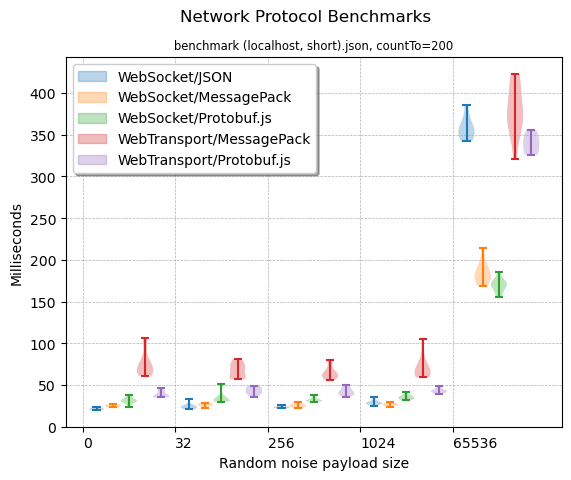

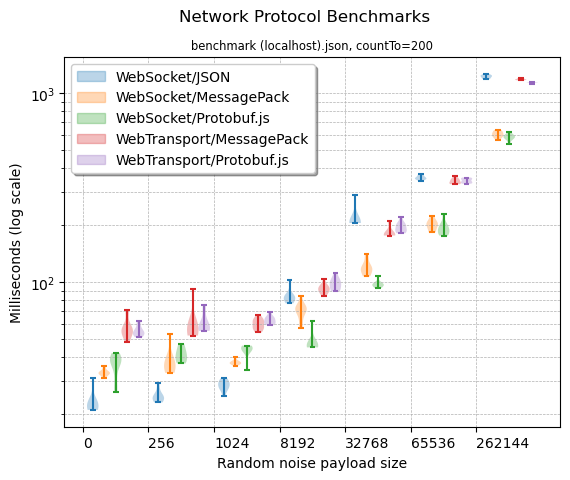

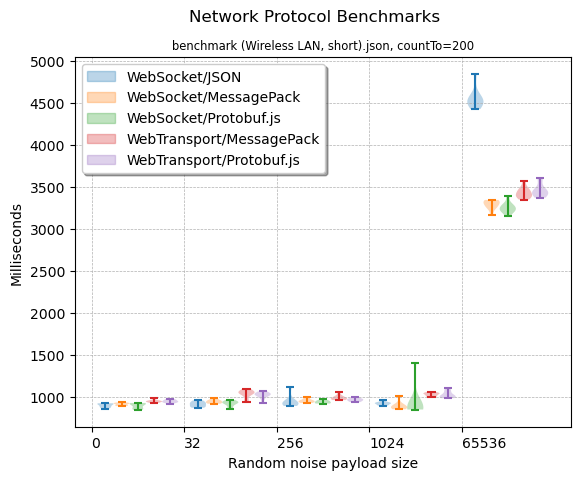

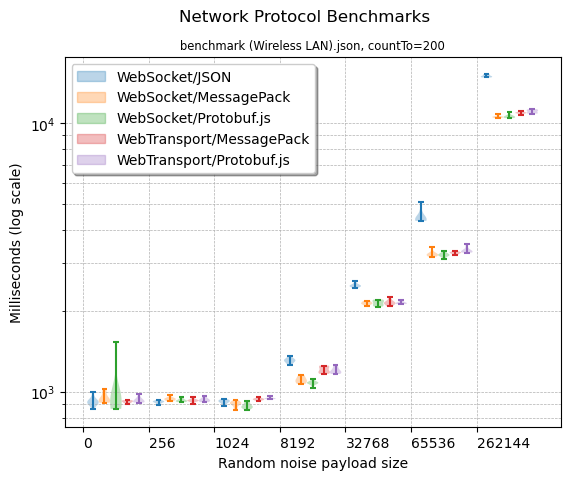

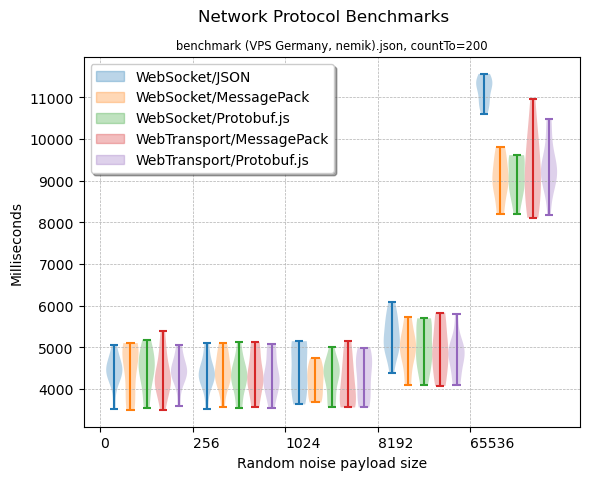

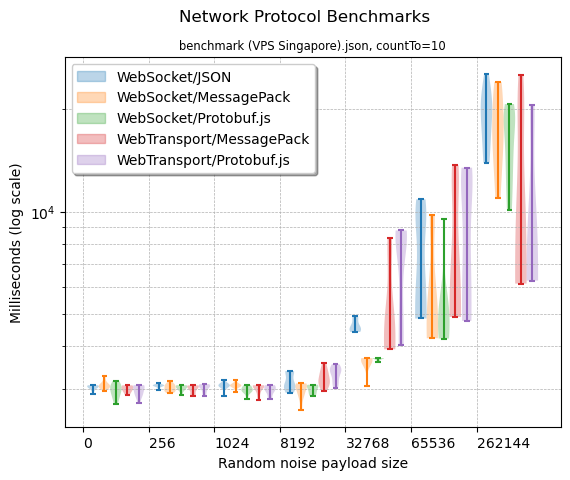

In [7]:
# localhost
render("benchmark (localhost, short).json") # short initial benchmark
render("benchmark (localhost).json", logscale=True) # more steps in noise size and up to 256k
# instead of high count, prefer more repetitions of lower counts
#render("benchmark (localhost, high count).json") # countTo: 2000

# running over wifi to server in lan
render("benchmark (Wireless LAN, short).json")
render("benchmark (Wireless LAN).json", logscale=True)

# running over wifi+internet to hetzner vps
render("benchmark (VPS Germany, nemik).json")
render("benchmark (VPS Singapore).json", logscale=True)

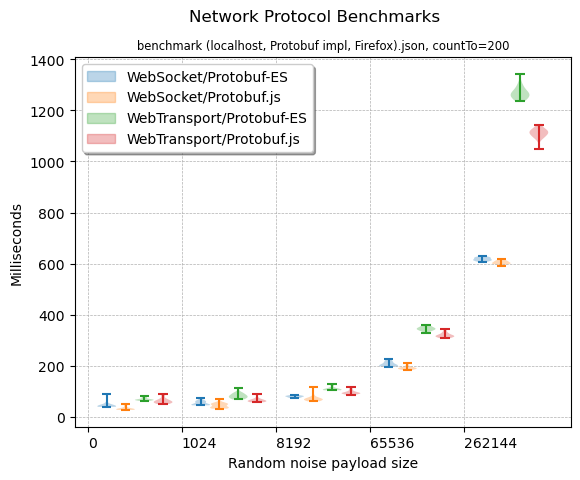

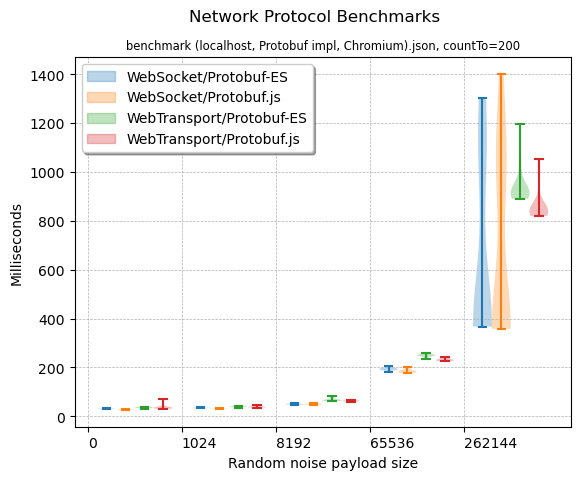

In [6]:
# compare different protobuf implementations in the browser and between browsers
render("benchmark (localhost, Protobuf impl, Firefox).json", spread=0.6)
render("benchmark (localhost, Protobuf impl, Chromium).json", spread=0.6)